# TFIDF V1

The goal of this notebook is to load data from multiple locations and compare their performance / validate.

In [2]:
import os
from datetime import datetime
import sys

sys.path.append("../scripts/twitter")
from searchTwitter import TwitterDataFrame

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
import emoji

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

np.random.seed(23)

# Set up sns
sns.set(rc = {'figure.figsize':(10,10)})
sns.set_style("whitegrid")

In [ ]:
# Reads files in a directory as csv and returns dataframe
def concat_data(base_dir):
    files = os.listdir(base_dir)
    dfs = []
    for f in files:
        if ".csv" in f:
            dfs.append(pd.read_csv(base_dir + f))
        
    return pd.concat(dfs)

In [7]:
dfs = []
cities = ["phoenix", "portland", "san_francisco", "seattle"]
for city,_ in cities:
    df = concat_data("../data/{}/".format(city))
    df['city'] = city
    dfs.append(df)
    
# Turn into a TwitterDataFrame
df_raw = TwitterDataFrame(pd.concat(dfs))
df_raw.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_13752/485934091.py:7: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(base_dir + f))


,id,author_id,text,geo,created_at,lat,lon,city
0,1024082187115622400,1708905816,Time for Monday Night Raw! #RAW,{'place_id': '5c62ffb0f0f3479d'},2018-07-30 23:59:54,33.290260,-112.323914,phoenix
1,1024082144958636037,795028712408293376,@14bigjay88 @tate_slade_obsf they aren't gonna...,{'place_id': '0015d9147cee6907'},2018-07-30 23:59:44,33.384785,-112.357999,phoenix
2,1024082071222808577,275357706,@NicoleBarbaro Thanks for sharing! My younger ...,{'place_id': '7cb7440bcf83d464'},2018-07-30 23:59:26,33.319945,-111.979047,phoenix
3,1024082016969486337,20756054,@Telegraph I like all the people who are too b...,{'place_id': '5c62ffb0f0f3479d'},2018-07-30 23:59:14,33.290260,-112.323914,phoenix
4,1024081978864193536,601192710,"Adios, Arizona. Until next time 💔",{'place_id': '006b48995ede9bcc'},2018-07-30 23:59:04,33.204608,-111.842244,phoenix


In [10]:
df_raw = df_raw.dropna().reset_index(drop=True)
df_raw['created_at'] = [datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in df_raw['created_at']]   

# Subset 5/2018-12/2018
df_raw = df_raw[df_raw['created_at'] > datetime(2018, 4, 30)]

# Change date quantum to day
df_raw['date'] = df_raw['created_at'].dt.floor('d')

df_raw = TwitterDataFrame(df_raw)
df_raw.head()

TypeError: strptime() argument 1 must be str, not Timestamp

In [9]:
# Read in the daily AQI in 2018 California
aqi_2018 = pd.read_csv('../data/daily_aqi_by_county_2018.csv')

aqi_df = []
for county, state in [("Maricopa", "Arizona"), ("San Francisco", "California"), ("Multnomah", "Oregon"), ("King", "Washington")]:
    aqi_df.append(aqi_2018[(aqi_2018['State Name']==state) & (aqi_2018['county Name']==county)])

# Subset just SF country and extract dates
aqi_df = pd.concat(aqi_df)
aqi_df['Date'] = pd.to_datetime(aqi_df['Date'])

aqi_df.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
9213,Arizona,Maricopa,4,13,2018-01-01,249,Very Unhealthy,PM2.5,04-013-0019,30
9214,Arizona,Maricopa,4,13,2018-01-02,79,Moderate,PM2.5,04-013-0019,30
9215,Arizona,Maricopa,4,13,2018-01-03,77,Moderate,PM10,04-013-9812,30
9216,Arizona,Maricopa,4,13,2018-01-04,82,Moderate,PM10,04-013-9812,30
9217,Arizona,Maricopa,4,13,2018-01-05,73,Moderate,PM10,04-013-4009,30


In [11]:
# What are the basics of the data set?
print("Lenth: ", len(df_raw))
print("Per day :", len(df_raw)/365)

Lenth:  3332806
Per day : 9130.975342465754


In [12]:
spec_re = "[^A-Za-z0-9\?\!\@]+"
http_re = "https?:\S+|http?:\S"
at_re = "@\S+"

def process_tweet(tweet):
    tweet = str(tweet).lower()
    tweet = emoji.demojize(tweet)
    tweet = re.sub(spec_re, ' ', tweet)
    tweet = re.sub(http_re, 'HTTPURL', tweet)
    tweet = re.sub(at_re, '@USER', tweet)
    # Tokenize and stem?
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

df_raw['text'] = df_raw['text'].apply(process_tweet)

df_raw.head()

,id,author_id,text,geo,created_at,lat,lon,city,date
0,1024082187115622400,1708905816,time for monday night raw! raw,{'place_id': '5c62ffb0f0f3479d'},2018-07-30 23:59:54,33.290260,-112.323914,phoenix,2018-07-30
1,1024082144958636037,795028712408293376,@USER @USER slade obsf they aren t gonna say s...,{'place_id': '0015d9147cee6907'},2018-07-30 23:59:44,33.384785,-112.357999,phoenix,2018-07-30
2,1024082071222808577,275357706,@USER thanks for sharing! my younger lab mate ...,{'place_id': '7cb7440bcf83d464'},2018-07-30 23:59:26,33.319945,-111.979047,phoenix,2018-07-30
3,1024082016969486337,20756054,@USER i like all the people who are too busy w...,{'place_id': '5c62ffb0f0f3479d'},2018-07-30 23:59:14,33.290260,-112.323914,phoenix,2018-07-30
4,1024081978864193536,601192710,adios arizona until next time broken heart,{'place_id': '006b48995ede9bcc'},2018-07-30 23:59:04,33.204608,-111.842244,phoenix,2018-07-30


In [ ]:
df_batch = TwitterDataFrame(df_raw).group_by_days_and_batch(1000)
df_batch.shape

(1923, 2)

In [ ]:
df_mrg = pd.merge(left=df_batch, right=df_raw, left_on='date', right_on='Date', how='inner')
print(df_mrg.columns)
df_clean = df_mrg.drop(columns=['State Name', 'county Name', 'State Code', 'County Code', 'Date', "Defining Parameter", "Defining Site", "Number of Sites Reporting"])

In [ ]:
# write clean csvs for each city
for city in cities:
    df = df_clean[df_clean['city'] == city]
    df.to_csv("../data/cleaned/{}_cleaned.csv".format(city), index=False)

In [ ]:
df_clean.to_csv("../data/cleaned/four_cities.csv", index=False)
df_clean.head()

,date,text,AQI,Category
0,2018-05-01,@USER @USER that s the neighborhood i grew up ...,37,Good
1,2018-05-01,@USER i ain t seen one meme from u smh i m wai...,37,Good
2,2018-05-01,birthday month love you gesture medium dark sk...,37,Good
3,2018-05-01,@USER io @USER only problem is it may be too h...,37,Good
4,2018-05-01,the american dream narrative system wasn t cre...,37,Good


#### Note: to start from previously cleaned data begin here

In [ ]:
sf_clean = pd.read_csv("../data/four_cities.csv", parse_dates=['date'])
sf_clean.head()

,date,text,AQI,Category
0,2018-05-01,@USER @USER that s the neighborhood i grew up ...,37,Good
1,2018-05-01,@USER i ain t seen one meme from u smh i m wai...,37,Good
2,2018-05-01,birthday month love you gesture medium dark sk...,37,Good
3,2018-05-01,@USER io @USER only problem is it may be too h...,37,Good
4,2018-05-01,the american dream narrative system wasn t cre...,37,Good


#### Experiment: word counts

In [ ]:
word_freq = sf_clean.text.str.split(expand=True).stack().value_counts()
word_count = word_freq.sum()
word_freq

@USER            1960725
i                 861179
the               845483
to                637867
a                 547576
                  ...   
biostream?             1
wowwwww!!!!!!          1
0brien                 1
1?!?!?                 1
clownstick             1
Length: 371168, dtype: int64

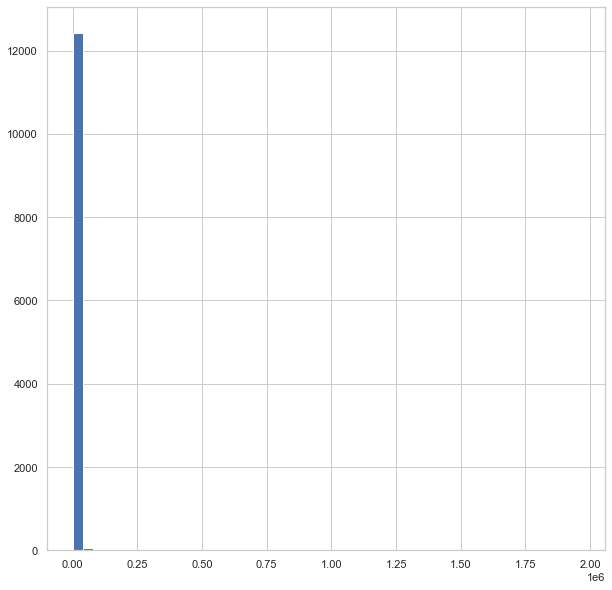

In [ ]:
plt.hist(word_freq, bins=50, range=[word_freq.min()+100, word_freq.max()]);

In [ ]:
# Fire increased a lot when I added emojis 🔥
key_words = ["asthma","lung","cough","smoke","fire", "smog","aqi","air"]
key_freq = word_freq[key_words]
key_freq, word_count

asthma      122
lung         92
cough       462
smoke      3269
fire      15374
smog         71
aqi          73
air        4094
dtype: int64

In [ ]:
min_df = key_freq.min() / word_count
max_df = key_freq.max() / word_count + 0.05

min_df, max_df

(2.319639835076875e-06, 0.010502283701753126)

### Model Code below

In [ ]:
train_df, test_df = train_test_split(sf_clean, test_size=0.2, random_state=23)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
# This creates a train-test split based off of days
dates = sf_clean.date.unique()
np.random.shuffle(dates)
train_dates, test_dates = train_test_split(dates, test_size=0.2, random_state=23)
train_df = sf_clean[sf_clean['date'].isin(train_dates)]
test_df = sf_clean[sf_clean['date'].isin(test_dates)]

In [ ]:
train_df.head()

,date,text,AQI,Category
0,2018-05-01,@USER @USER that s the neighborhood i grew up ...,37,Good
1,2018-05-01,@USER i ain t seen one meme from u smh i m wai...,37,Good
2,2018-05-01,birthday month love you gesture medium dark sk...,37,Good
3,2018-05-01,@USER io @USER only problem is it may be too h...,37,Good
4,2018-05-01,the american dream narrative system wasn t cre...,37,Good


In [ ]:
X_train = train_df['text']
X_test = test_df['text']

y_train = train_df['AQI']
y_test = test_df['AQI']

### Experiment 1: Finding a baseline with K-Means Regression

In [ ]:
# min_df sets the min document frequency for accepted words
tf_vect = TfidfVectorizer(min_df=min_df, max_df=max_df).fit(X_train)
words = tf_vect.get_feature_names_out()
X_train_enc = tf_vect.transform(X_train)
X_test_enc = tf_vect.transform(X_test)

In [ ]:
X_train_enc.shape, X_train.shape

((1525, 223218), (1525,))

In [ ]:
y_train = train_df['AQI'].apply(np.log2)
y_test = test_df['AQI'].apply(np.log2)
y_train

0       5.209453
1       5.209453
2       5.209453
3       5.209453
4       5.209453
          ...   
1918    4.906891
1919    4.906891
1920    4.906891
1921    4.906891
1922    4.906891
Name: AQI, Length: 1525, dtype: float64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Fit Regression model
knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1).fit(X_train_enc, y_train)

In [ ]:
y_pred = knn_model.predict(X_train_enc)
knn_model.score(X_train_enc, y_train)


0.9363091730894646

In [ ]:
y_pred_test = knn_model.predict(X_test_enc)
knn_model.score(X_test_enc, y_test)


0.13041171521850436

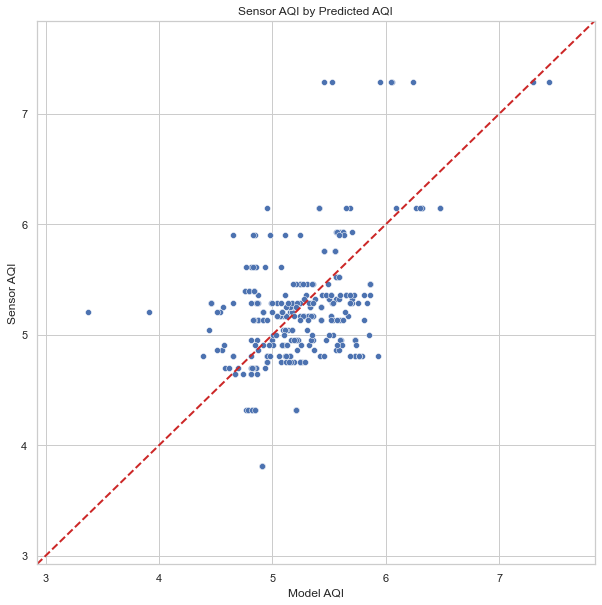

In [ ]:
# Plots predictions by their true value
def plot_reference(y_pred, y_train, draw_ref=True):
    # Draw reference lines
    if draw_ref:
        X = np.linspace(0, 240, 240)
        plt.plot(X, X, '--', color="#cc2727", linewidth=2)

    plot = sns.scatterplot(x=y_pred, y=y_train)

    # Set plot style
    max_lim = max(y_pred)
    min_lim = min(y_pred)
    max_lim += (max_lim-min_lim) / 10
    min_lim -= (max_lim-min_lim) / 10

    plot.set(ylim=(min_lim, max_lim))
    plot.set(xlim=(min_lim, max_lim))

    plot.set_title("Sensor AQI by Predicted AQI")
    plot.set_ylabel("Sensor AQI", fontsize = 12)
    plot.set_xlabel("Model AQI", fontsize = 12)

# plot_reference(y_pred, y_train)
plot_reference(y_pred_test, y_test)